In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf

from skimage.io import imread
from matplotlib.colors import TwoSlopeNorm
from scipy.ndimage import convolve, correlate, sobel


from tensorflow.keras import datasets, layers, models

# Images and Convolutions
### The simple, complex and convoluted notions behind computer vision

#### References



1. Image Kernels - https://setosa.io/ev/image-kernels/
2. Wikipedia 
    + Convolution - https://en.wikipedia.org/wiki/Convolution
    + Dirach delta - https://en.wikipedia.org/wiki/Dirac_delta_function
    + Kronecker delta - https://en.wikipedia.org/wiki/Kronecker_delta
    + Kernel (image processing) - https://en.wikipedia.org/wiki/Kernel_(image_processing)
    + Sobel operator - https://en.wikipedia.org/wiki/Sobel_operator
3. Paper oriented edge detection https://hal.science/hal-01940320/file/%5BMagnierEUSIPCO2017%5D_Oriented%20Asymmetric_Kernels_for_Corner_Detection_v2.pdf
4. https://docs.scipy.org/
5. https://docs.opencv.org/
6. https://www.geeksforgeeks.org/python-opencv-cv2-blur-method/


#### Helper functions

In [3]:
def plot_image_subplots(images, titles=None, subplot_kwargs=None, nrows=1, ncols=3, figsize_hor=12, figsize_ver=6, no_ticks=True):
    """
    Plots a grid of images with titles, allowing for different keyword arguments for each subplot.

    Parameters:
    images : list of array-like
        List of images to plot.
    titles : list of str, optional
        List of titles for each subplot. Default is None.
    plot_kwargs : list of dict, optional
        List of dictionaries with keyword arguments for plt.imshow for each subplot. 
        If not provided, a default colormap of 'gray' is used.
    nrows : int, optional
        Number of rows in the subplot grid. Default is 1.
    ncols : int, optional
        Number of columns in the subplot grid. Default is 3.
    figsize_hor : int, optional
        Horizontal size of the entire figure. Default is 12.
    figsize_ver : int, optional
        Vertical size of the entire figure. Default is 6.
    no_ticks : bool, optional
        If True, removes ticks from the plots. Default is True.

    Example:
    plot_image_subplots(
        images=[image_1, image_2, image_3],
        titles=["Title 1", "Title 2", "Title 3"],
        plot_kwargs=[
            {"cmap": "gray"},
            {"cmap": "Reds_r", "vmin": 0, "vmax": 1},
            {"cmap": "Blues_r", "vmin": -1, "vmax": 1}
        ],
        nrows=1,
        ncols=3,
        figsize_hor=15,
        figsize_ver=5
    )
    """
    if titles is None:
        titles = ["" for _ in images]
    else:
        assert len(images) == len(titles), "Number of images not equal to number of titles"

    if subplot_kwargs is None:
        subplot_kwargs = [{} for _ in images]
    else:
        assert len(images) == len(subplot_kwargs), "Number of images not equal to number of plot_kwargs"

    for kwargs in subplot_kwargs:
        if "cmap" not in kwargs:
            kwargs["cmap"] = "gray"

    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_hor, figsize_ver))
    axs = axs.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        axs[i].imshow(image, **subplot_kwargs[i])
        axs[i].set_title(title)

    if no_ticks:
        plt.setp(axs, xticks=[], yticks=[])

    plt.tight_layout()
    plt.show()


In [4]:
def plot_convolutions(image, filters, titles = None, subplot_kwargs = None, **plot_kwargs):
    """
    Plot images resulting from convolution with given filters.
    """
    conv_results = [(convolve(image, filter)) for filter in filters]
    plot_image_subplots(conv_results, titles, subplot_kwargs, **plot_kwargs)

In [5]:
def plot_heatmaps(arrays, titles = None, nrows = 1, ncols = 2, figsize_hor = 12, figsize_ver = 3, cmap_limit = 0.1):
    """
    Plots several heatmaps in subplots with a common colorbar.

    array_info : list of tuples
            - filter (array-like)
            - title (str)
            
    Example input:
        plot_heatmaps(
        [
            (filter1, "Filter 1"), 
            (filter2, "Filter 2")
        ], 
        nrows=1, 
        ncols=2
        )
    """
    if titles is None:
        titles = ["" for _ in arrays]
    else:
        assert len(arrays) == len(titles), "Number of arrays not equal to number of titles"

    # Create the figure and axes
    fig, axs = plt.subplots(nrows, ncols, figsize = (figsize_hor, figsize_ver), layout = "compressed")
    if len(arrays) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    # Find the global min and max values across all data for common scaling
    global_min = min(data.min() for data in arrays)
    global_max = max(data.max() for data in arrays)

    global_abs = max([abs(global_min), global_max])

    # Create a common normalization
    norm = TwoSlopeNorm(vmin = - cmap_limit - global_abs, vmax = cmap_limit + global_abs, vcenter = 0)

    # Plot each data array
    for ax, array, title in zip(axs, arrays, titles):
        cax = ax.imshow(array, cmap = "seismic", norm = norm)
        ax.set_title(title)
    
    # Add a single colorbar
    cbar = fig.colorbar(cax, ax=axs[:len(arrays)])
    
    # Remove axis ticks
    plt.setp(axs, xticks=[], yticks=[])
    
 
    plt.show()


## Background - Convolutions in Math

wiki https://en.wikipedia.org/wiki/Convolution

Convolution is a mathematical operation on two functions - $f$ and $g$ that produces a third function $ f*g $. It is defined as the integral of the product of the two functions after one is reflected about the y-axis and shifted.  The integral is evaluated for all values of shift, producing the convolution function.

$$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau) \, g(t - \tau) \, d\tau $$

This integral essentially slides one function over another, multiplying and summing their overlapping values to produce the output at each point. Here is a visualization of the the process of computing a convolution function:


![Convolution animation - Wikipedia](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)

In discrete form, for sequences $f[n]$ and $g[n]$  convolution is defined as:

$$ (f * g)[n] = \sum_{m=-\infty}^{\infty} f[m] \, g[n - m] $$

Which is quite complex way to describe what is actually a sliding window weighted sum - each output element $ (f * g)[n] $ is the sum of the products of the elements of $ f $ and $ g $ shifted by $ n $. 

Here is a visualization of discrete convolution of two 2d functions as in image processing. $ g $ is denoted as input, $ f $ - as kernel and $ f * g $ - as output.

![Discrete 2D Convolution Animation - Wikipedia](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

### Algebraic Properties

Some of the algebraic properties of a convolution are:

__Commutativity__:  $ f * g = g * f $

__Associativity__: $ f * (g * h) = (f * g) * h $

__Distributivity__: $ f * (g + h) = (f * g) + (f * h) $

__Multiplicative identity__: No algebra of functions possesses an identity for the convolution. Instead, a function can be convolved with a delta distribution (a unitary impulse, centered at zero) or approximations of the identity can be found. 

__Identity Element__:
$ f * \delta = f $, 
where $ \delta $ is the Dirac delta function for continuous convolution or the Kronecker delta for discrete convolution.



Dirac delta function $ \delta $, also known as unit impulse, is a function, whose value is zero everywhere except at zero, and whose integral over it's entire domain is equal to one. Since there is no function having this property, modelling the delta "function" usually involves the use of limits or measure theory and the theory of distributions.

![Dirac_function_approximation](https://upload.wikimedia.org/wikipedia/commons/b/b4/Dirac_function_approximation.gif)
<img src="https://www.probabilitycourse.com/images/chapter4/Delta-Pulse_b.png" alt="Delta-Pulse" style="height:300px;">



The Kronecker delta function $ \delta_{ij} $ is a function that returns 1 if the elements $ i $ and $j $ are equal and zero otherwise. In linear algebra, an identity matrix $ I_{m \times n} $ has entries equal to the Kronecker delta.

Kronecker delta: $ \delta_{ij} = 
\begin{cases} 
1 & \text{if } i = j \\
0 & \text{if } i \neq j 
\end{cases}
$
Identity matrix:
$
I_{m \times n} = 
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1
\end{bmatrix}
$




### Applications

Convolutions have many applications due to their ability to capture relationships and their relatively low computational complexity. Some applications across various disciplines:

+ In statistics, a weighted moving average is a convolution
+ In probability theory, the probability distribution of the sum of two independent random variables is the convolution of their individual distributions.
+ In acoustics, reverberation is the convolution of the original sound with echoes from objects surrounding the sound source.
+ In optics, an out-of-focus photograph is a convolution of the sharp image with a lens function. 
+ In electrical engineering, the convolution of one function (the input signal) with a second function (the impulse response) gives the output of a linear time-invariant system (LTI). 
+ And of course, image processing and computer vision - those we will discuss later in this work.



## Basic - Images as Matrices

In [6]:
cat_image_url = "https://d17fnq9dkz9hgj.cloudfront.net/uploads/2012/11/140272627-grooming-needs-senior-cat-632x475.jpg"
cat_image = imread(cat_image_url)
cat_image.shape

(475, 632, 3)

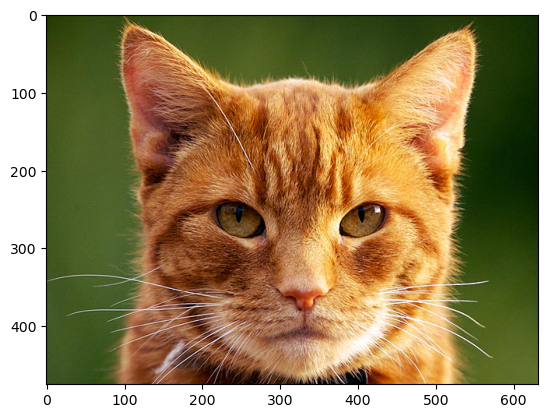

In [7]:
plt.imshow(cat_image)
plt.show()

In [8]:
# normalize
cat_image = cat_image / 255

# split channels
cat_image_r, cat_image_g, cat_image_b = [cat_image[:, :, i] for i in range(3)]



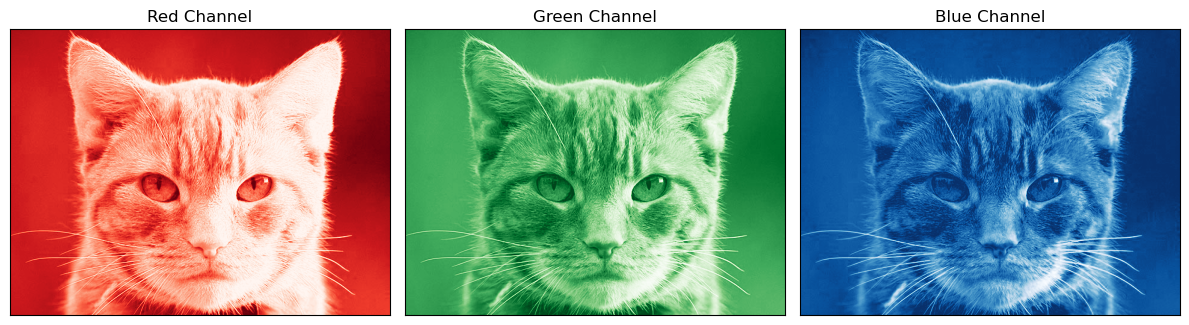

In [9]:
plot_image_subplots(
    images=[cat_image_r, cat_image_g, cat_image_b],
    titles=["Red Channel", "Green Channel", "Blue Channel"],
    subplot_kwargs=[{"cmap": "Reds_r"}, {"cmap": "Greens_r"}, {"cmap": "Blues_r"}],
)


In [10]:
cat_image_gray = (cat_image_r + cat_image_g + cat_image_b) / 3.0  
cat_image_gray_corrected = (0.299 * cat_image_r + 
                            0.587 * cat_image_g + 
                            0.114 * cat_image_b)

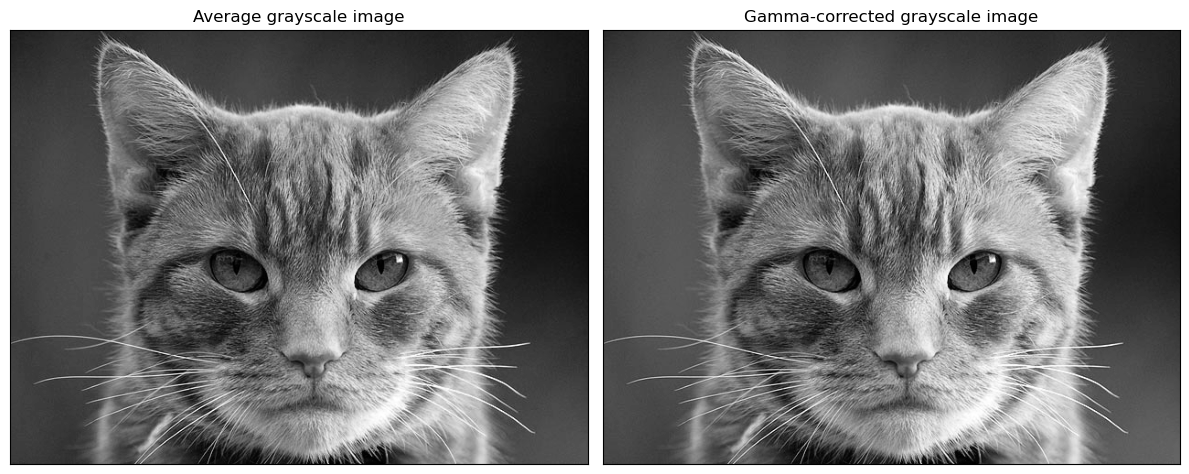

In [11]:
plot_image_subplots(
    images=[cat_image_gray, cat_image_gray_corrected],
    titles=["Average grayscale image", "Gamma-corrected grayscale image"],
    ncols=2
)


## Simple - Image Arithmetic

In [12]:
# let's call it cat
cat = cat_image_gray_corrected
cat.shape

(475, 632)

In [13]:
# Function to keep the range of pixel values; (0, 1) by default
def limit_range(pixel_value, min_value = 0, max_value = 1):  
    if pixel_value < min_value:
        pixel_value = min_value
    elif pixel_value > max_value:
        pixel_value = max_value
    return pixel_value

limit_range = np.vectorize(limit_range)

In [14]:
def custom_map(px):
    if px < 0.15:
        return 0
    elif px < 0.3:
        return 0.15
    elif px < 0.7:
        return px
    elif px < 0.85:
        return 0.7
    return 1

custom_map = np.vectorize(custom_map)

In [15]:
def black_and_white(px, limit_value = 0.5):
    if px < limit_value:
        return 0
    return 1

black_and_white = np.vectorize(black_and_white)

In [16]:
cat_add = limit_range(cat + 0.3)
cat_subtract = limit_range(cat - 0.1)
cat_multiply = limit_range(cat * 2)
cat_divide = limit_range(cat / 2)
cat_power_light = limit_range(cat ** 0.3)
cat_power_dark = limit_range(cat ** 3)
cat_map = custom_map(cat)
cat_black_and_white = black_and_white(cat)
cat_invert = cat * -1


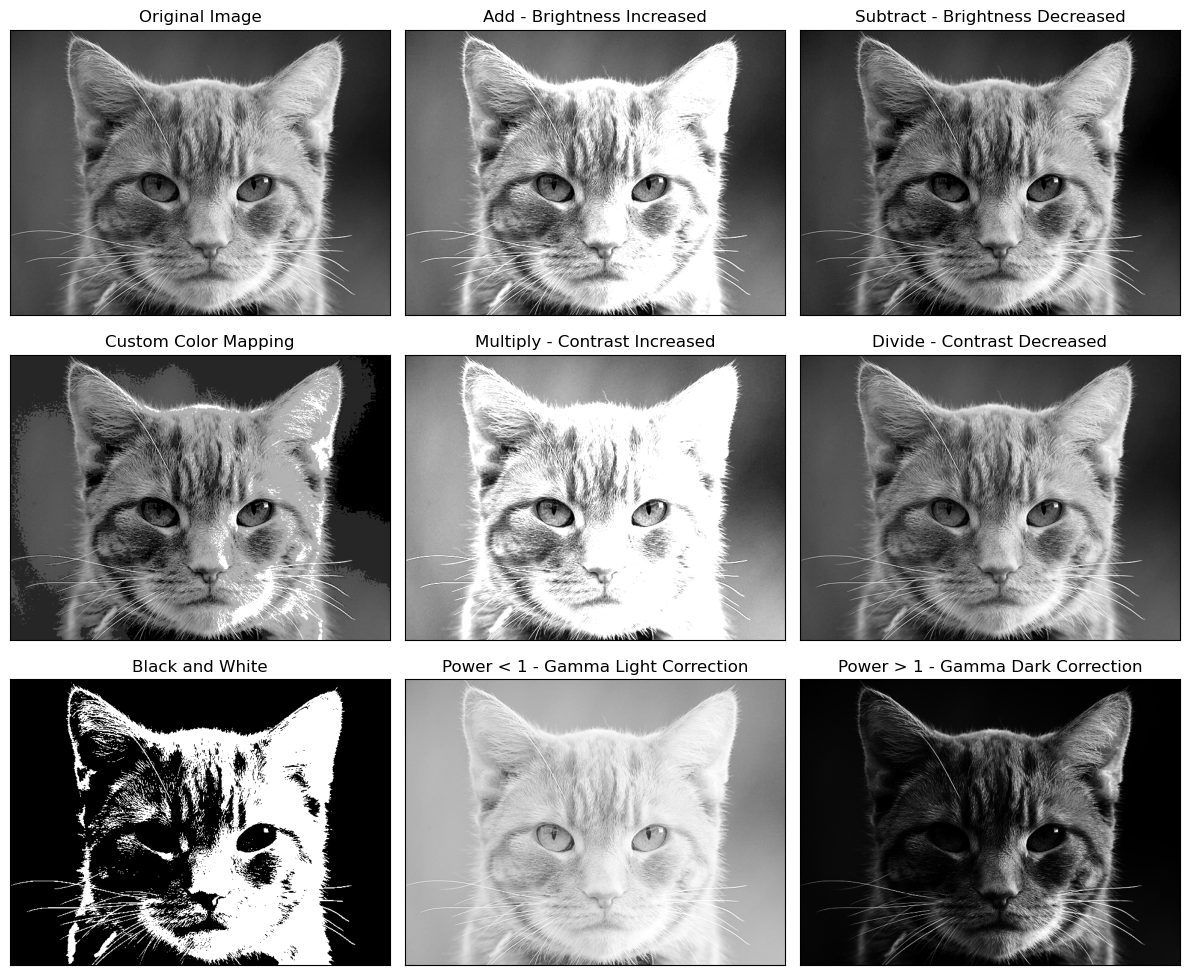

In [17]:
plot_image_subplots(
    images=[
        cat,
        limit_range(cat + 0.3),
        limit_range(cat - 0.1),
        custom_map(cat),
        limit_range(cat * 2),
        limit_range(cat / 2),
        black_and_white(cat),
        limit_range(cat ** 0.3),
        limit_range(cat ** 3)
    ],
    titles=[
        "Original Image",
        "Add - Brightness Increased",
        "Subtract - Brightness Decreased",
        "Custom Color Mapping",
        "Multiply - Contrast Increased",
        "Divide - Contrast Decreased",
        "Black and White",
        "Power < 1 - Gamma Light Correction",
        "Power > 1 - Gamma Dark Correction"
    ],
    nrows=3,
    figsize_ver=10
)



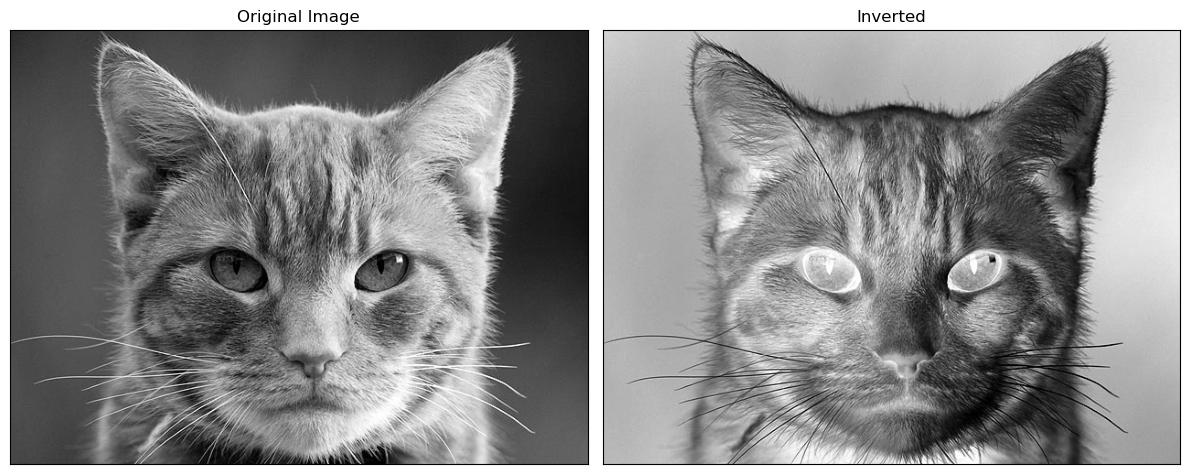

In [18]:
plot_image_subplots(
    images=[
        cat,
        cat * -1
    ],
    titles=[
        "Original Image",
        "Inverted"
    ],
    ncols=2
)


In [19]:
box_url = "https://shmector.com/_ph/10/356948332.png"
box_raw = imread(box_url)
box_raw.shape

(1500, 1500, 3)

In [20]:
#Normalize
box_image = box_raw.copy() / 255
#grayscale
box_image = box_image.mean(axis=2)


In [21]:
# our box is too big take every * pixel
box_image.shape

(1500, 1500)

In [22]:
def downsample_image(image, n):
    return image[::n, ::n]

In [23]:
box = downsample_image(box_image, 4)
box.shape

(375, 375)

In [24]:
# pad
pad_x = 100
pad_y = 125


box = np.pad(
    box, 
    ((pad_x, 475-box.shape[0]-pad_x), (pad_y, 632-box.shape[1]-pad_y)), 
    'constant', constant_values = 1
    )



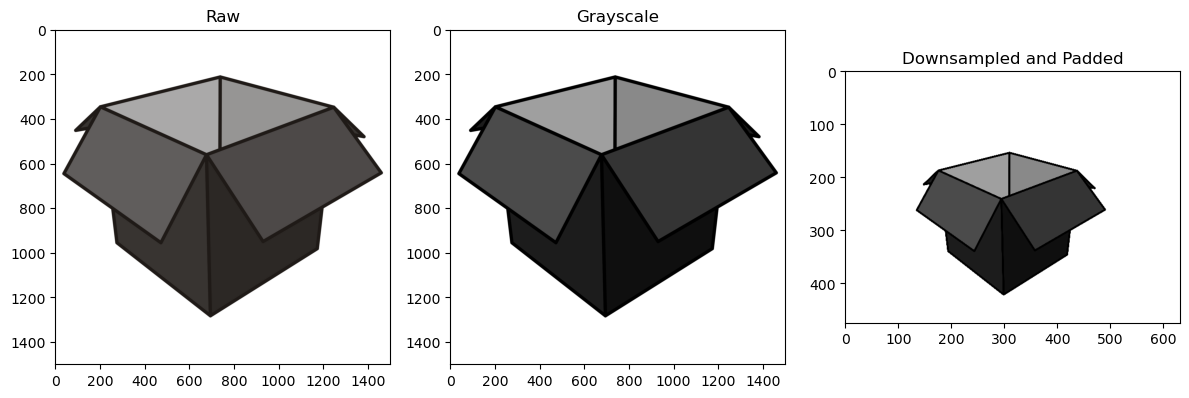

In [25]:
plot_image_subplots(
    images=[
        box_raw,
        box_image,
        box
    ],
    titles=[
        "Raw",
        "Grayscale",
        "Downsampled and Padded"
    ],
    no_ticks=False
)


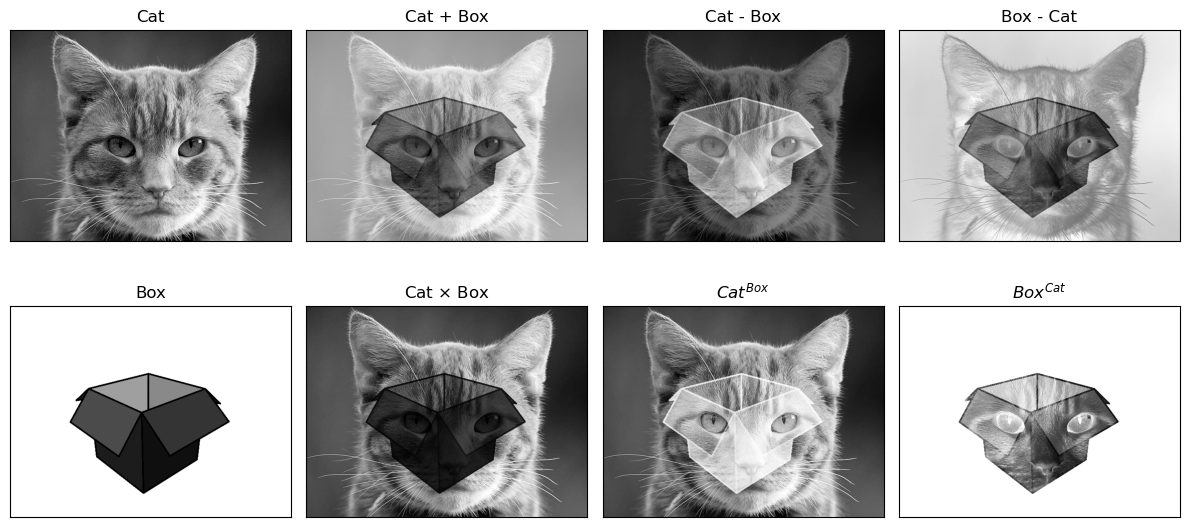

In [26]:
plot_image_subplots(
    images=[
        cat,
        cat + box,
        cat - box,
        box - cat,
        box,
        cat * box,
        cat ** box,
        box ** cat
    ],
    titles=[
        "Cat",
        "Cat + Box",
        "Cat - Box",
        "Box - Cat",
        "Box",
        r"Cat $ \times $ Box",
        r"$Cat^{Box}$",
        r"$Box^{Cat}$"
    ],
    nrows=2,
    ncols=4
)


## Complex - Image Convolutions

In [27]:
conv_filter = np.array([
    [1, 2, -3],
    [4, 5, -6],
    [7, 8, -9]
])

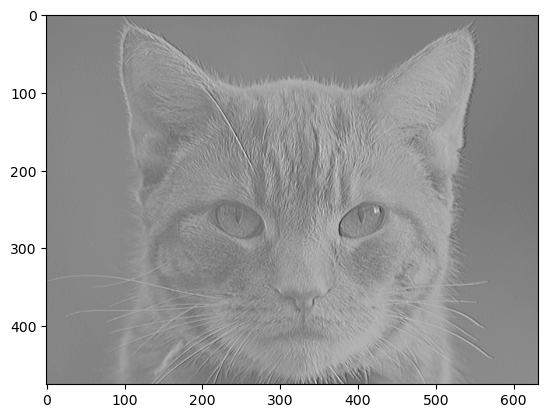

In [28]:
plt.imshow(convolve(cat, conv_filter), cmap = "gray")
plt.show()

### Image convolution with numpy

Each value in result is 
, where W is the weights kernel, j is the N-D spatial index over 
, I is the input and k is the coordinate of the center of W, specified by origin in the input parameters.

In [29]:
def convolve_np(image, filter, flip_filter = True):
    n, m = image.shape
    s = filter.shape[0]
    assert filter.shape[0] == filter.shape[1], "Filter must be a square matrix"
    assert s % 2 == 1, "Filter size must be an odd number"

    # Pad the image with zeros
    pad_width = s // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

    # Prepare the output array
    output_array = np.zeros_like(image)

    # ... convolution vs correlation -> flip kernel
    if flip_filter:
        filter = np.flip(filter)

    # Perform the convolution
    for i in range(n):
        for j in range(m):
            # Extract sliding window
            window = padded_image[i:i+s, j:j+s]
            # Perform element-wise multiplication and sum the result
            output_array[i, j] = np.sum(window * filter)
    
    return output_array

In [30]:
mock_image = cat[:5, :5]


In [31]:
numpy_conv = convolve_np(mock_image, conv_filter)
numpy_conv_no_flip = convolve_np(mock_image, conv_filter, flip_filter=False)

In [32]:
scipy_conv = convolve(mock_image, conv_filter, mode = "constant", cval = 0)
scipy_conv

array([[ 2.03322353,  0.50830588,  0.52791373,  0.55447059, -0.34850196],
       [ 4.57385882,  1.52223529,  1.57197647,  1.62722353, -0.52364706],
       [ 4.56849412,  1.51687059,  1.56929412,  1.62326667, -0.52261961],
       [ 4.56198824,  1.50882353,  1.56392941,  1.62838431, -0.51175686],
       [ 4.05765882,  1.52109412,  1.56423137,  1.62506667, -0.33507059]])

In [33]:
scipy_corr = correlate(mock_image, conv_filter, mode = "constant", cval = 0)
scipy_corr

array([[-0.33887059,  1.52491765,  1.46609412,  1.52512157,  4.15341176],
       [-0.50025882,  1.52581176,  1.44896471,  1.51315294,  4.66275294],
       [-0.50204706,  1.52044706,  1.44628235,  1.49511765,  4.66865098],
       [-0.50524314,  1.52621176,  1.45472941,  1.50510588,  4.68465098],
       [-0.3384902 ,  0.50984706,  0.47455294,  0.49778039,  2.08503922]])

In [34]:
scipy_conv_flip = np.flip(scipy_conv)
scipy_conv_flip

array([[-0.33507059,  1.62506667,  1.56423137,  1.52109412,  4.05765882],
       [-0.51175686,  1.62838431,  1.56392941,  1.50882353,  4.56198824],
       [-0.52261961,  1.62326667,  1.56929412,  1.51687059,  4.56849412],
       [-0.52364706,  1.62722353,  1.57197647,  1.52223529,  4.57385882],
       [-0.34850196,  0.55447059,  0.52791373,  0.50830588,  2.03322353]])

In [35]:
assert np.allclose(scipy_conv, numpy_conv)
assert np.allclose(scipy_corr, numpy_conv_no_flip)

In [36]:
np.allclose(scipy_corr, scipy_conv_flip, rtol = 0.12)

True

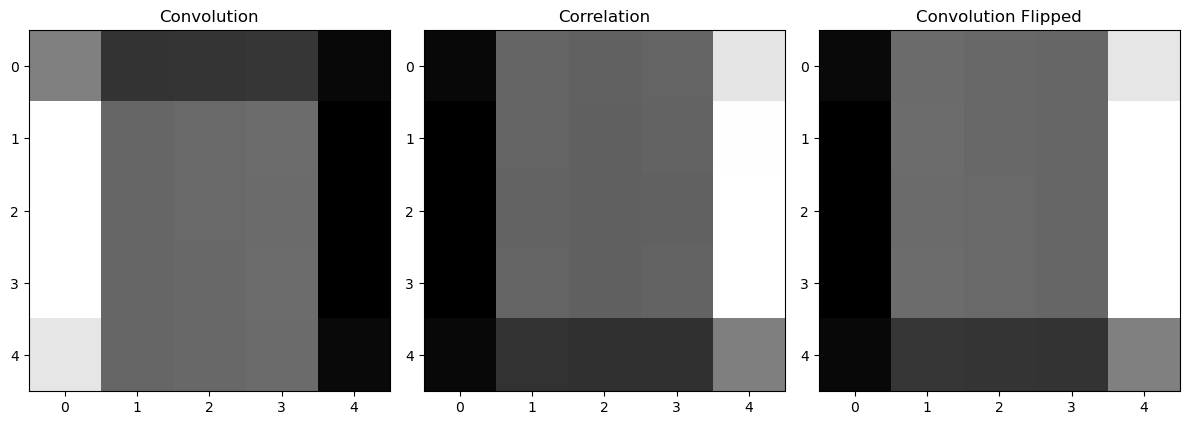

In [37]:
plot_image_subplots(
    [
    scipy_conv, 
    scipy_corr,
    scipy_conv_flip, 
    ], 
    titles = [
    "Convolution",
    "Correlation",
    "Convolution Flipped"
    ],
    no_ticks = False
)

### Common filters

#### Identity, ones, minus ones

In [38]:
# identity
identity_filter = np.array([
    [0,0,0], 
    [0,1,0],
    [0,0,0]
])

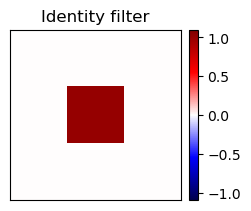

In [39]:
plot_heatmaps(
    [identity_filter], 
    titles=["Identity filter"], 
    ncols=1, 
    figsize_ver = 2
)

In [40]:
 # filter with 1, 1, 1 does nothing
ones_filter = np.ones([3, 3])

In [41]:
minus_ones_filter = ones_filter.copy() * -1
minus_ones_filter

array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

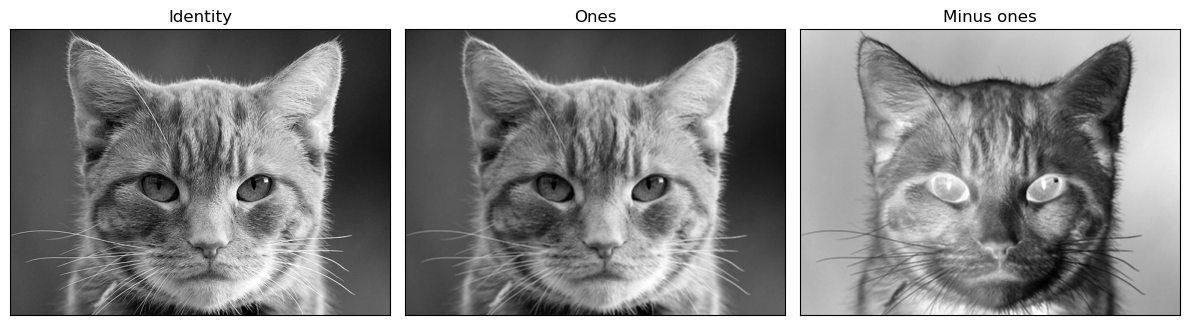

In [42]:
plot_convolutions(
    cat, 
    filters = [
        identity_filter, 
        ones_filter, 
        minus_ones_filter
    ],
    titles = [
        "Identity",
        "Ones",
        "Minus ones"
    ]  
)

#### Mean Filter - Blurr

In [43]:
### Mean Filter - Box Blurr

In [44]:
# mean makes it blurry
# How is blurr useful -> get rid of noise (see also Gaussian blurr)
def mean_filter(s):
    # Box blurr
    return np.ones([s, s]) / s**2

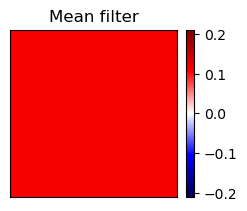

In [45]:
plot_heatmaps([mean_filter(3)], titles =  ["Mean filter"], ncols = 1, figsize_ver = 2)

In [46]:
eye = cat[220:420, 200:400]

In [47]:
filter_sizes = [3, 5, 7]
mean_filters = [mean_filter(s) for s in filter_sizes]
mean_filter_titles = [f"Mean filter ${s} \\times {s}$" for s in filter_sizes]

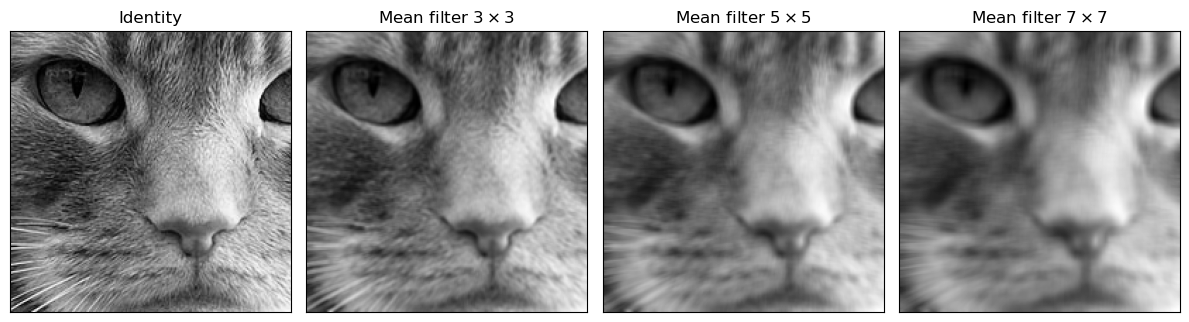

In [48]:
plot_convolutions(
    eye,
    filters = [identity_filter] + mean_filters,
    titles = ["Identity"] + mean_filter_titles, 
    ncols = 4
)

In [49]:
filter_size = 11
blur_scipy = convolve(cat, mean_filter(filter_size))
blur_cv = cv2.blur(cat, (filter_size, filter_size))

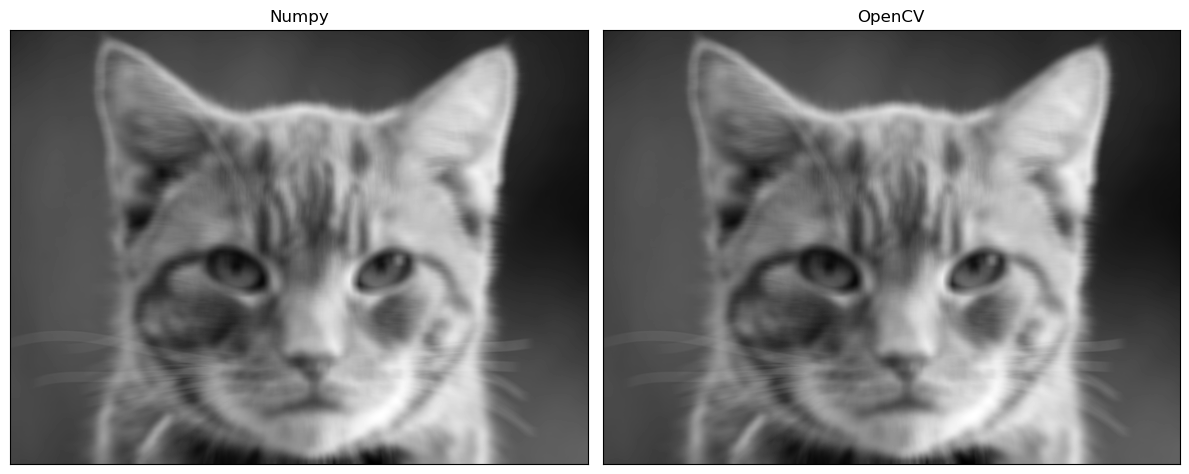

In [50]:


plot_image_subplots(
    [
        blur_scipy,
        blur_cv,
    ], 
    titles = [
        "Numpy",
        "OpenCV"
    ],
    ncols = 2)

In [51]:
blur_scipy.shape, blur_cv.shape

((475, 632), (475, 632))

In [52]:
idx_start = 5
idx_end = -6

In [53]:
np.allclose(
    blur_scipy[idx_start:idx_end, idx_start:idx_end], 
    blur_cv[idx_start:idx_end, idx_start:idx_end],
)

True

In [54]:
np.allclose(
    blur_scipy[:idx_start, :], 
    blur_cv[:idx_start, :],
)

False

In [55]:
np.allclose(
    blur_scipy[:idx_start, :], 
    blur_cv[:idx_start, :],
    rtol = 0.1
)

True

importance of hidden defaults

scipy.ndimage.convolve mode default is reflect

‘reflect’ (
`d c b a | a b c d | d c b a`
)
The input is extended by reflecting about the edge of the last pixel. This mode is also sometimes referred to as half-sample symmetric.

cv2 
cv.BORDER_DEFAULT === same as BORDER_REFLECT_101
`gfedcb|abcdefgh|gfedcba`

haha, REFLECT ON DEFAULTS

In [56]:
blur_scipy = convolve(cat, mean_filter(filter_size), mode="constant")
blur_cv = cv2.blur(cat, (filter_size, filter_size), borderType=cv2.BORDER_CONSTANT)

In [57]:
np.allclose(
    blur_scipy, 
    blur_cv,
)

True

#### Gausian Blur

In [58]:
def gaussian_kernel(size, sigma = 1.0):
    """Generate a (size x size) Gaussian kernel with standard deviation sigma.
    
    The size parameter must be an odd number.
    """
    assert size % 2 == 1, "Size must be an odd number."
    
    # Create an (size x size) grid of (x, y) coordinates
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
  
    xx, yy = np.meshgrid(ax, ax)

    
    # Calculate the Gaussian function
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    # Normalize the kernel to ensure the sum is 1
    kernel = kernel / np.sum(kernel)
    
    return kernel

In [59]:
gauss_1d = [
    cv2.getGaussianKernel(3, 0).T,
    cv2.getGaussianKernel(5, 0).T,
    cv2.getGaussianKernel(7, 0).T,
    cv2.getGaussianKernel(3, 0.5).T,
    cv2.getGaussianKernel(5, 0.5).T, 
    cv2.getGaussianKernel(7, 0.5).T, 
    cv2.getGaussianKernel(3, 1).T, 
    cv2.getGaussianKernel(5, 1).T, 
    cv2.getGaussianKernel(7, 1).T, 
]

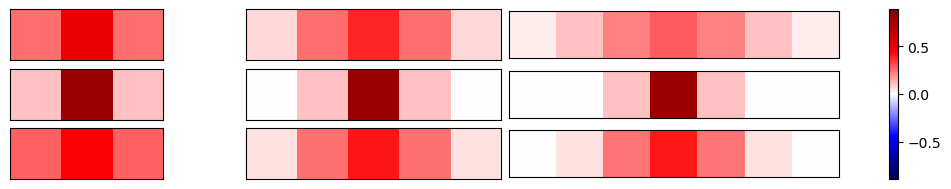

In [60]:
plot_heatmaps(gauss_1d, ncols = 3, nrows=3)

<div style="display: flex; justify-content: space-around;">

<div style="margin: 10px;">
Approximate 3x3 Gaussian kernel:

$$
\frac{1}{16} \begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$
</div>

<div style="margin: 10px;">
Approximate 5x5 Gaussian kernel:

$$
\frac{1}{273} \begin{bmatrix}
1 &  4 &  7 &  4 & 1 \\
4 & 16 & 26 & 16 & 4 \\
7 & 26 & 41 & 26 & 7 \\
4 & 16 & 26 & 16 & 4 \\
1 &  4 &  7 &  4 & 1
\end{bmatrix}
$$
</div>

<div style="margin: 10px;">
Approximate 7x7 Gaussian kernel:

$$
\frac{1}{1003} \begin{bmatrix}
  0 &  0 &  1 &  2 &  1 &  0 &  0 \\
  0 &  3 & 13 & 22 & 13 &  3 &  0 \\
  1 & 13 & 59 & 97 & 59 & 13 &  1 \\
  2 & 22 & 97 &159 & 97 & 22 &  2 \\
  1 & 13 & 59 & 97 & 59 & 13 &  1 \\
  0 &  3 & 13 & 22 & 13 &  3 &  0 \\
  0 &  0 &  1 &  2 &  1 &  0 &  0 
\end{bmatrix}
$$
</div>

</div>


In [61]:
gauss_approx_3 = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16
gauss_approx_3

array([[0.0625, 0.125 , 0.0625],
       [0.125 , 0.25  , 0.125 ],
       [0.0625, 0.125 , 0.0625]])

In [62]:
gauss_3 = gaussian_kernel(3)
gauss_3

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

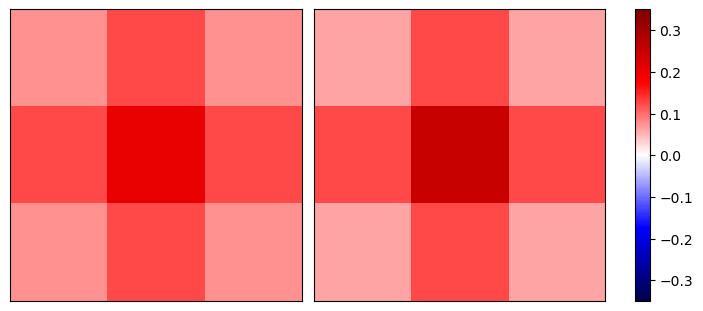

In [63]:
plot_heatmaps([gauss_3, gauss_approx_3, ])

In [64]:
np.allclose(gauss_3, gauss_approx_3), np.allclose(gauss_3, gauss_approx_3, rtol = 0.25)

(False, True)

In [65]:
gauss_approx_5 = np.array([
    [1,  4,  7,  4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1,  4,  7,  4, 1]
]) / 273
gauss_approx_5

array([[0.003663  , 0.01465201, 0.02564103, 0.01465201, 0.003663  ],
       [0.01465201, 0.05860806, 0.0952381 , 0.05860806, 0.01465201],
       [0.02564103, 0.0952381 , 0.15018315, 0.0952381 , 0.02564103],
       [0.01465201, 0.05860806, 0.0952381 , 0.05860806, 0.01465201],
       [0.003663  , 0.01465201, 0.02564103, 0.01465201, 0.003663  ]])

In [66]:
gauss_5 = gaussian_kernel(5)
gauss_5

array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]])

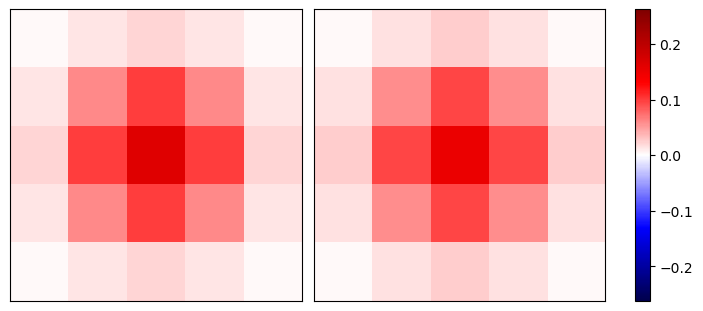

In [67]:
plot_heatmaps([gauss_5, gauss_approx_5])

In [68]:
np.allclose(gauss_5, gauss_approx_5), np.allclose(gauss_5, gauss_approx_5, rtol = 0.25)

(False, True)

In [69]:
gauss_approx_7 = np.array([
    [  0,   0,   1,   2,   1,   0,   0],
    [  0,   3,  13,  22,  13,   3,   0],
    [  1,  13,  59,  97,  59,  13,   1],
    [  2,  22,  97, 159,  97,  22,   2],
    [  1,  13,  59,  97,  59,  13,   1],
    [  0,   3,  13,  22,  13,   3,   0],
    [  0,   0,   1,   2,   1,   0,   0]
]) / 1003



In [70]:
gauss_7 = gaussian_kernel(7)


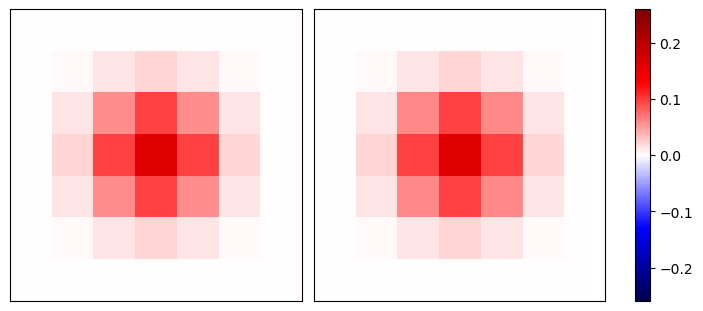

In [71]:
plot_heatmaps([gauss_7, gauss_approx_7])

In [72]:
np.allclose(gauss_7, gauss_approx_7), np.allclose(gauss_7, gauss_approx_7, rtol = 0.9)

(False, False)

In [73]:
eye = cat[230:300, 200:300]

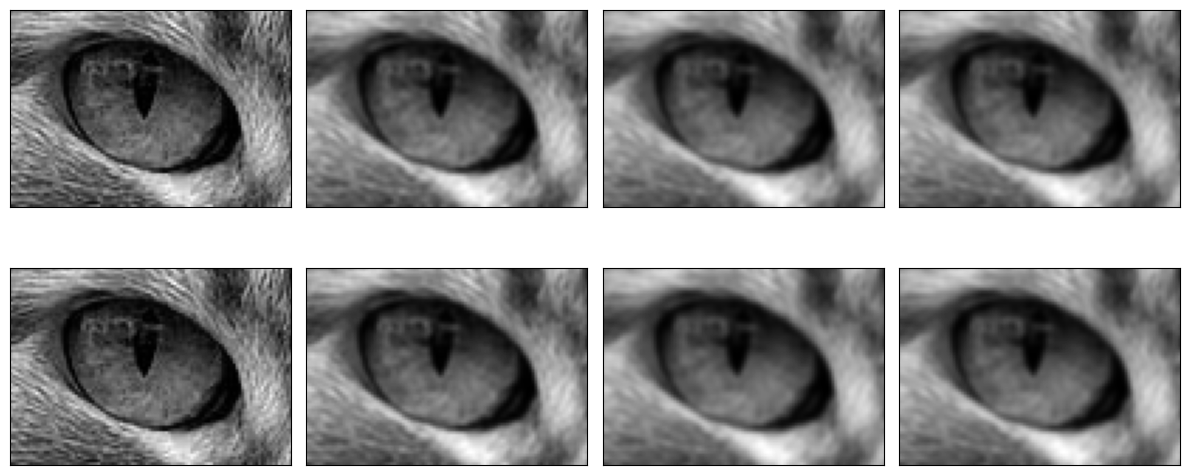

In [74]:
plot_convolutions(eye, filters = [
    identity_filter, 
    gauss_3, 
    gauss_5, 
    gauss_7, 
    identity_filter, 
    gauss_approx_3, 
    gauss_approx_5, 
    gauss_approx_7, 

], ncols=4, nrows=2)

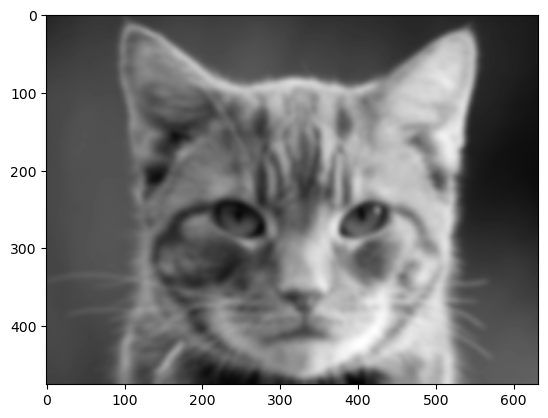

In [75]:
plt.imshow( cv2.GaussianBlur(cat, (21, 21), 0), cmap = "gray")

#### Sobel Filters - Edge Detection

sobel operator wiki

Since the Sobel kernels can be decomposed as the products of an averaging and a differentiation kernel, they compute the gradient with smoothing. For example, 

$ \mathbf {G} _{x} $ and 
$ \mathbf {G} _{y} $ can be written as



Averaging kernel
$
  \begin{bmatrix}
  1 & 2 & 1 
  \end{bmatrix}
$

Diferentiation kernel
$
  \begin{bmatrix}
   1 & 0 & -1
  \end{bmatrix}
$

In [76]:
avg_filter = np.array([[1, 2, 1]])
diff_filter = np.array([[1, 0, -1]])

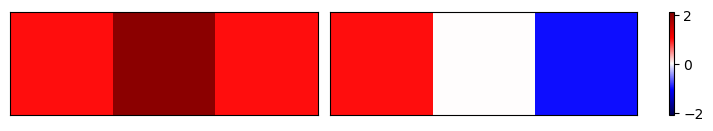

In [77]:
plot_heatmaps([
    avg_filter,
    diff_filter
], figsize_ver = 1.2)

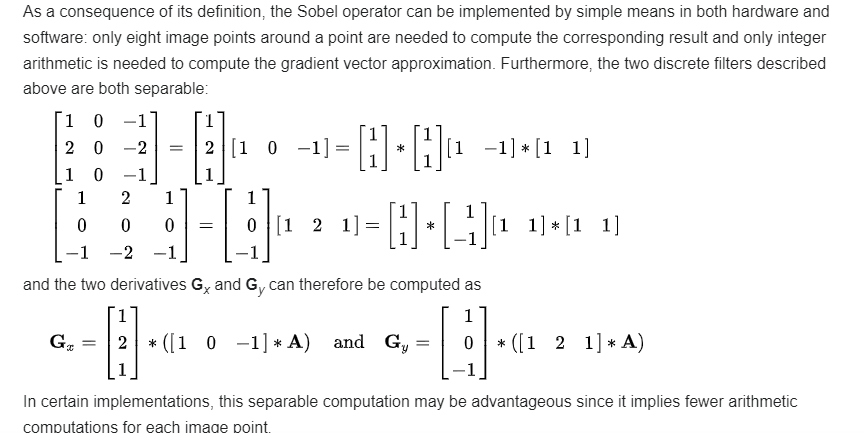

- For horizontal changes (Gx):
  $$
  G_x = \begin{bmatrix}
  1 & 0 & -1 \\
  2 & 0 & -2 \\
  1 & 0 & -1
  \end{bmatrix}
  $$

- For vertical changes (Gy):
  $$
  G_y = \begin{bmatrix}
  1 & 2 & 1 \\
  0 & 0 & 0 \\
  -1 & -2 & -1
  \end{bmatrix}
  $$


In [78]:
# elements for edge detection - Sobel
hor_edge_filter = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])
ver_edge_filter = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

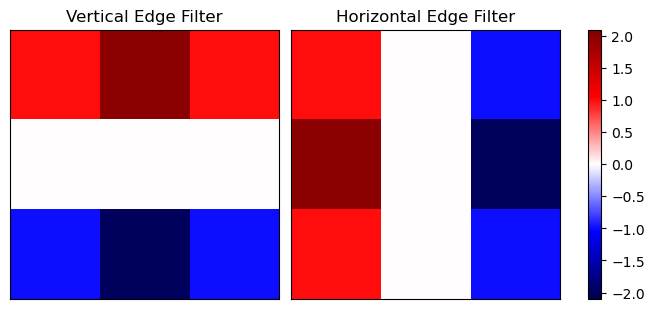

In [79]:
plot_heatmaps(
    [
        ver_edge_filter,
        hor_edge_filter
    ],
    titles = [
        "Vertical Edge Filter",
        "Horizontal Edge Filter"
    ] 
)

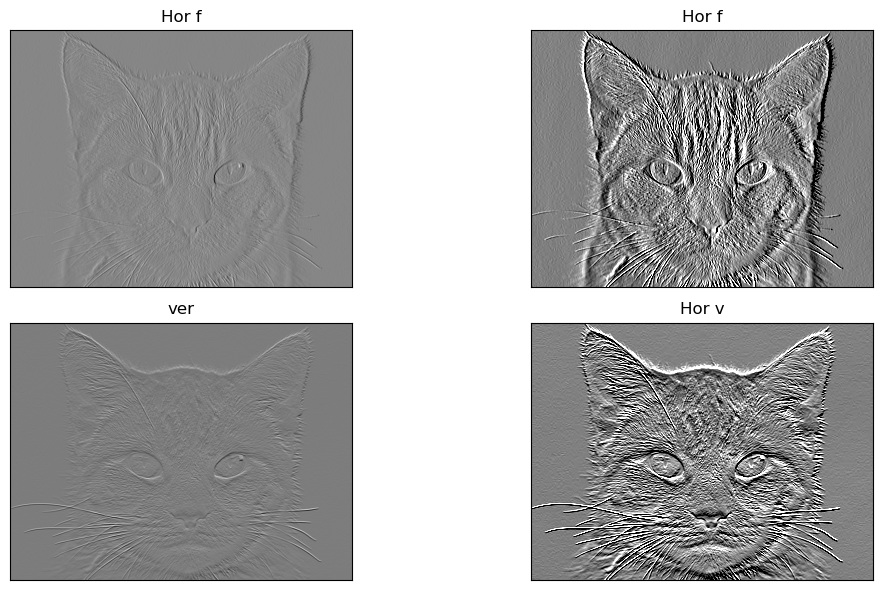

In [80]:
v = 0.4
plot_convolutions(
    cat, 
    filters =[
        hor_edge_filter,
        hor_edge_filter, 
        ver_edge_filter, 
        ver_edge_filter, 
    ], 
    titles = [
        "Hor f",
        "Hor f",
        "ver",
        "Hor v"
    ],
    subplot_kwargs = [
        {},
        {"vmin": -v, "vmax": v},
        {},
        {"vmin": -v, "vmax": v}
    ],
    nrows = 2, 
    ncols = 2
)

In [81]:

# Apply Sobel operator
sobel_x = sobel(cat, axis=0)
sobel_y = sobel(cat, axis=1)

# Combine the two gradients
sobel_combined = np.hypot(sobel_x, sobel_y)


In [82]:
edges_combined = np.hypot(convolve(cat, hor_edge_filter), convolve(cat, hor_edge_filter))

In [83]:
sobel_x.shape

(475, 632)

In [84]:
sobel_combined.min(), sobel_combined.max()

(0.0, 4.035227579874076)

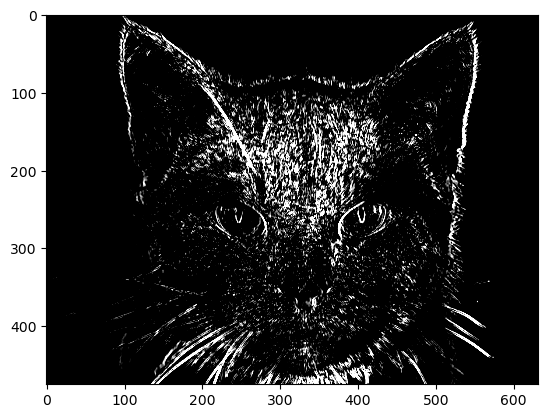

In [85]:
plt.imshow(edges_combined, cmap = "gray", vmin=0.4, vmax=1)
plt.show()

In [86]:
cat.dtype

dtype('float64')

In [87]:

dst = cv2.cornerHarris(np.float32(cat), blockSize=2, ksize=3, k=0.04)
dst.max(), dst.min()

(0.013493989, -0.028839761)

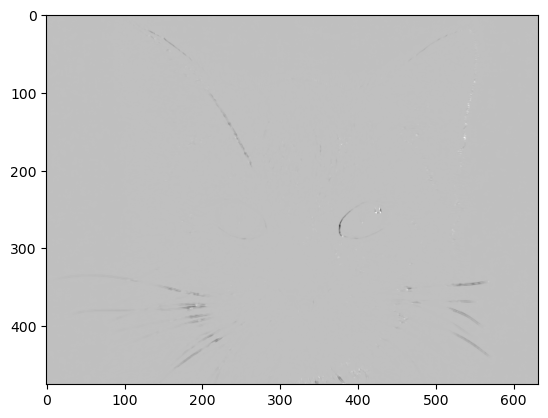

In [88]:
plt.imshow(dst, cmap='gray', vmin=-0.03, vmax=0.01)
plt.show()

https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

In [89]:
dst = cv2.cornerHarris(np.float32(cat), blockSize=2, ksize=3, k=0.04)

r = cat.copy()
g = cat.copy()
b = cat.copy()

# Makes dots bigger
dst = cv2.dilate(dst, np.ones((5, 5), np.uint8))
 
# Threshold for an optimal value, it may vary depending on the image.
limit_value = 0.02
r[dst>limit_value*dst.max()]=1
g[dst>limit_value*dst.max()]=0
b[dst>limit_value*dst.max()]=0

rgb = np.dstack((r,g,b))

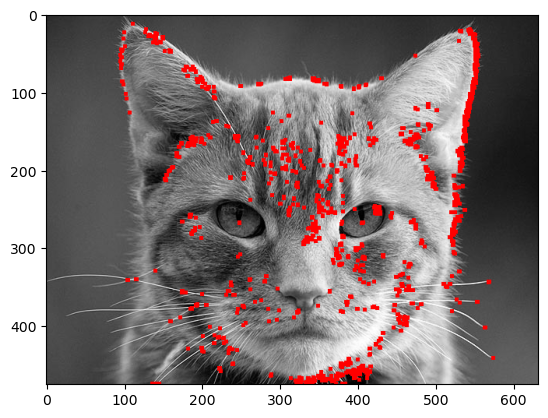

In [90]:
plt.imshow(rgb)
plt.show()

vmin and vmax are min value in the image and max value in the image, small num (here -20, 20) for better contrast of the resulting image, for visualisation only. Vmin to vmax for normal grayscale 0 - 255, here min is - 800ish and max is +800ish.

difference in the values of adjesent pixels is called GRADIENT, high gradient == edge (ръб)

vertex(vertices) - edge of edges (връх)

### Erosion and Dilation

https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/

https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html

![Example-of-dilation-and-erosion-in-a-matrix](https://www.researchgate.net/profile/Slimane-Larabi/publication/281654372/figure/fig2/AS:733035053985794@1551780584377/Example-of-dilation-and-erosion-in-a-matrix.ppm)

<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgXsfjxmtZepI49-xZpsp9__x9KdV0pWGKnuKwfZIyGtlWfeRl0k36SHn7GK19dhEPys1v8pVpPUp3de-5tAkCCJl1VLmeazHxpBI28OHqvq91lIkrvDmV9sY80ZyE1IQ3lAlIu5b5puy92/s1600/result.png" alt="Erosion and Dilation Example 1" style="height:300px;">
<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhJuQ0ddTSRqQPAOkrguAph0RuQBcJm82hpV5SJZoMDaR7EXmU3fbZ2gWnqfUhHeJmDdNyTmwirXcXrJU2ORzTSugqs7i_OWgiFN5qs87FhIwVTF1cHwMZY4whz-YbTbZMEHgAMteYy_YUB/s1600/result2.png" alt="Erosion and Dilation Example 1" style="height:300px;">

[images source](https://imagingknowledgebin.blogspot.com/2013/08/morphological-operations.html)


In [2]:
kernel = np.ones((5, 5), np.uint8)
kernel_big = np.ones((11, 11), np.uint8)
image = cat

plot_image_subplots(
    [
        image, 
        cv2.dilate(cv2.erode(image, kernel, iterations=1), kernel, iterations = 1), 
        cv2.erode(cv2.dilate(image, kernel, iterations=1), kernel, iterations = 1), 
        cv2.erode(image, kernel, iterations=1), 
        cv2.erode(image, kernel, iterations=5), 
        cv2.erode(image, kernel_big, iterations=1),
        cv2.dilate(image, kernel, iterations=1),
        cv2.dilate(image, kernel, iterations=5), 
        cv2.dilate(image, kernel_big, iterations=1), 
    ], 
    titles = [
        "Original Image",
        "Opening - Erode then Dilate",
        "Closing - Dilate then Erode",
        "Erode",
        "Erode  - More Iterations",
        "Erode - Bigger Kernel",
        "Dilate",
        "Dilate - More iterations",
        "Dilate - Bigger Kernel",
    ],
    nrows=3, 
    ncols = 3, 
    figsize_ver=10
)


NameError: name 'cat' is not defined

## Convolutional Neural Networks

In [3]:


# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

# Convert labels to binary: 1 for class '8', 0 for others
train_labels = (train_labels == 8).astype(int)
test_labels = (test_labels == 8).astype(int)

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(1, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # Single convolutional layer with 1 filter
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')


: 

In [ ]:
test_images[0].shape

(28, 28, 1)

In [ ]:
idx_to_plot = range(4*8)
images_to_plot = np.array([test_images[i] for i in idx_to_plot])
predictions = model.predict(images_to_plot)
titles = [f"{prob[0]:.4f}" for prob in predictions.tolist()]



1/1 [==============================] - 0s 115ms/step


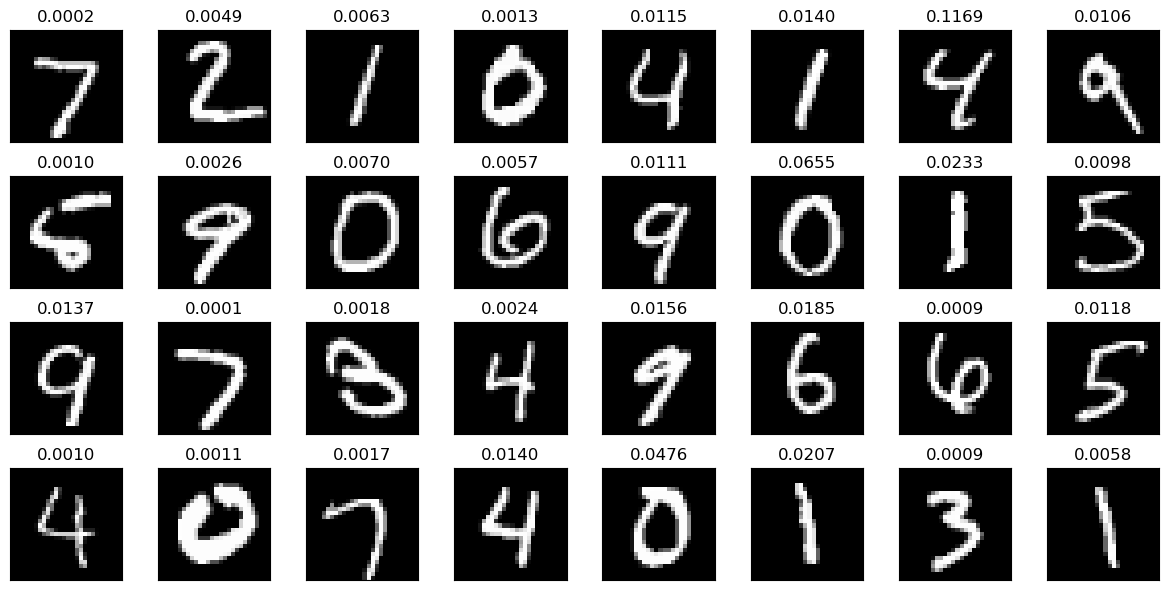

In [ ]:
plot_image_subplots(images_to_plot, titles=titles, nrows = 4, ncols = 8)

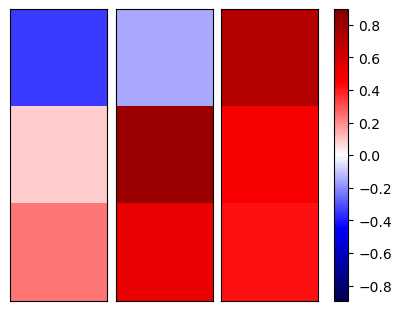

In [ ]:
conv_layer = model.layers[0]
kernel_weights, bias = conv_layer.get_weights()

plot_heatmaps(kernel_weights, ncols=3)

In [ ]:
kernel_weights

array([[[[-0.3457374 ]],

        [[ 0.08500817]],

        [[ 0.24124144]]],


       [[[-0.15131728]],

        [[ 0.7945317 ]],

        [[ 0.5171823 ]]],


       [[[ 0.6998973 ]],

        [[ 0.46294546]],

        [[ 0.41510323]]]], dtype=float32)